# Racing Line Calculator

Calculating the racing line of a specific track or circuit is a complex puzzle that cannot be solved with a simple, or I would say, one-size-fits-all solution.

Racing Line is neither about the shortest distance travelled nor having a high average speed alone.

Instead, it is about the __Optimal Path__ of a track which gives Racer the opportunity to :-
1) Sustain the highest average speed possible in straight line
1) Minimise time spent in apex cornering

This notebook illustrates an optimisation method using __Gradient Descent__ approach to calculate the racing line for a given track.<br>
Note that this demonstration does not utilise any _Machine Learning_ or _Deep Learning_ Python packages.

### Notes

1) The __Coordinate system__ adheres to __Unity's__ convention, where :-
   - Top View coordinates are represented as __(x,z)__ instead of (x,y)
   - The y-axis indicates elevation from the floor
1) However, in this __Notebook__, we will __rearrange__ the coordinate format :-
   - From __(x,z,y)__ to __(x,y,z)__ for standardisation purposes

## Install relevant Python packages

In [1]:
%%capture

pip install -r requirements.txt --upgrade

## Import Packages

In [2]:
import warnings
from tqdm.notebook import tqdm

In [3]:
import pandas as pd
import numpy as np
import math

In [4]:
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LineString

import matplotlib.pyplot as plt
from scipy import interpolate

In [5]:
from matplotlib.animation import FuncAnimation
from IPython import display

In [6]:
from dataclasses import dataclass
import copy as cp

In [7]:
%matplotlib widget

## Read the Track's Waypoints 2D

In [8]:
waypoints = pd.read_csv('data/evolt-karting.csv')
waypoints.head(5)

,inner_x,inner_y,inner_z,outer_x,outer_y,outer_z,center_x,center_y,center_z
0,0.180056,0,0.070201,0.179936,0,0.035659,0.179996,0,0.052930
1,0.171056,0,0.070196,0.170936,0,0.035641,0.170996,0,0.052918
2,0.162056,0,0.070191,0.161937,0,0.035622,0.161996,0,0.052906
3,0.153056,0,0.070185,0.152937,0,0.035603,0.152996,0,0.052894
4,0.144056,0,0.070180,0.143936,0,0.035584,0.143996,0,0.052882


In [9]:
waypoints.tail(5)

,inner_x,inner_y,inner_z,outer_x,outer_y,outer_z,center_x,center_y,center_z
470,0.202087,0,0.070919,0.217538,0,0.040124,0.209813,0,0.055522
471,0.200715,0,0.070482,0.209097,0,0.037076,0.204906,0,0.053779
472,0.199309,0,0.070232,0.200243,0,0.035620,0.199776,0,0.052926
473,0.197545,0,0.070244,0.197545,0,0.035512,0.197545,0,0.052878
474,0.188545,0,0.070181,0.188545,0,0.035573,0.188545,0,0.052877


### Determine whether the Track is a Closed Loop track

In [10]:
IS_TRACK_LOOPED = True

In [11]:
if IS_TRACK_LOOPED:
    new_row = waypoints.head(1)
    waypoints = pd.concat([waypoints, new_row], ignore_index=True)

In [12]:
waypoints.head(5)

,inner_x,inner_y,inner_z,outer_x,outer_y,outer_z,center_x,center_y,center_z
0,0.180056,0,0.070201,0.179936,0,0.035659,0.179996,0,0.052930
1,0.171056,0,0.070196,0.170936,0,0.035641,0.170996,0,0.052918
2,0.162056,0,0.070191,0.161937,0,0.035622,0.161996,0,0.052906
3,0.153056,0,0.070185,0.152937,0,0.035603,0.152996,0,0.052894
4,0.144056,0,0.070180,0.143936,0,0.035584,0.143996,0,0.052882


In [13]:
waypoints.tail(5)

,inner_x,inner_y,inner_z,outer_x,outer_y,outer_z,center_x,center_y,center_z
471,0.200715,0,0.070482,0.209097,0,0.037076,0.204906,0,0.053779
472,0.199309,0,0.070232,0.200243,0,0.035620,0.199776,0,0.052926
473,0.197545,0,0.070244,0.197545,0,0.035512,0.197545,0,0.052878
474,0.188545,0,0.070181,0.188545,0,0.035573,0.188545,0,0.052877
475,0.180056,0,0.070201,0.179936,0,0.035659,0.179996,0,0.052930


## Data Type Definitions

### 2D Point

In [14]:
@dataclass
class Point2D:
    """Data Class for creating a 2D point object"""
    coordinate: list
    x: float
    y: float
    
    def __init__(self, x, y):
        self.coordinate = [x, y]
        self.x = x
        self.y = y

### 3D Point

In [15]:
@dataclass
class Point3D:
    """Data Class for creating a 3D point object"""
    coordinate: list
    x: float
    y: float
    z: float
    
    def __init__(self, x, y, z):
        self.coordinate = [x, y, z]
        self.x = x
        self.y = y
        self.z = z

### 2D Waypoints

In [16]:
@dataclass
class Waypoints2D:
    """Data Class for creating a Waypoints 2D object"""
    points2D: list
    list_x: list
    list_y: list
    length: int
    
    def __init__(self, waypoints_x, waypoints_y):
        self.points2D = [Point2D(a[0], a[1]) for a in zip(waypoints_x, waypoints_y)]
        self.list_x = waypoints_x if type(waypoints_x) == list else waypoints_x.tolist()
        self.list_y = waypoints_y if type(waypoints_y) == list else waypoints_y.tolist()
        self.length = len(self.list_x)
        
    def dropLastRow(self):
        self.points2D = self.points2D[:-1]
        self.list_x.pop()
        self.list_y.pop()
        self.length = len(self.list_x)
        
    def addLastRow(self):
        self.points2D.append(self.points2D[0])
        self.list_x.append(self.list_x[0])
        self.list_y.append(self.list_y[0])
        self.length = len(self.list_x)
        
    def getCoordinateList(self):
        coors = []
        for point in self.points2D:
            coors.append(point.coordinate)
        return coors
    
    def updatePoint(self, index, x, y):
        self.points2D[index] = Point2D(x, y)
        self.list_x[index] = x
        self.list_y[index] = y
        self.length = len(self.list_x)

### 2D Vectors

In [17]:
@dataclass
class Vector2D:
    """Data Class for creating a 2D vector object"""
    vector: list
    x: float
    y: float
    
    def __init__(self, x, y):
        self.vector = [x, y]
        self.x = x
        self.y = y

## Prepare Lines

### Inner Line

In [18]:
inner_line = Waypoints2D(waypoints['inner_x'],
                         waypoints['inner_z'])

### Outer Line

In [19]:
outer_line = Waypoints2D(waypoints['outer_x'],
                         waypoints['outer_z'])

### Center Line

In [20]:
center_line = Waypoints2D(waypoints['center_x'],
                          waypoints['center_z'])

## Draw the Track Layout

In [21]:
class trackDraw:
    """Class for creating a Track Drawer object"""
    plt = None
    title = None
    fig_size = (6,8)
    car_position = None
    
    def __init__(self, plt, title="Track"):
        self.plt = plt
        self.title = title
        
    def drawTrack2D(self, inner_line, outer_line):
        self.plt.figure(figsize=self.fig_size)
        self.plt.axes().set_facecolor('black')
        
        outer_line_x, outer_line_y = outer_line.xy
        self.plt.plot(outer_line_x, outer_line_y, 'darkcyan', linewidth=1, label='Outer Line')
        inner_line_x, inner_line_y = inner_line.xy
        self.plt.plot(inner_line_x, inner_line_y, 'darkcyan', linewidth=1, label='Inner Line')
        
    def drawCenterLine(self, line):
        line_x, line_y = line.xy
        self.plt.plot(line_x, line_y, '--y', linewidth=0.6, label='Center Line')
        
    def drawRacingLine(self, line, colour='-r', label='Racing Line'):
        line_x, line_y = line.xy
        self.plt.plot(line_x, line_y, colour, linewidth=0.8, label=label)
        
    def plotCoordinates(self, line, colour='r', to_label=False):
        line_x, line_y = line.xy
        self.plt.plot(line_x, line_y, '.', color='white', alpha=0.7, linewidth=3)
        index = 0
        if to_label:
            for i in range(0, len(line_x)-1):
                self.plt.annotate(i, (line_x[i], line_y[i]), fontsize=7, color='white')
        
    def drawTrack2DPolygon(self, poly_inner_line, poly_outer_line):
        self.plt.figure(figsize=self.fig_size)
        self.plt.axes().set_facecolor('black')
        
        outer_x, outer_y = poly_outer_line.exterior.xy
        self.plt.fill(outer_x, outer_y, color='r', label='Outer Line')
        inner_x, inner_y = poly_inner_line.exterior.xy
        self.plt.fill(inner_x, inner_y, color='b', label='Inner Line')
        
    def __animate(self, n_frame, line):
        new_position = line.points2D[n_frame]
        self.car_position.set_data(new_position.x, new_position.y)
        
    def showAnimatedRacingLine(self, line, colour='lime', label='Car', car_size=5, animation_interval=20):
        car_positions = self.plt.plot([], 'o', color=colour, 
                                      markersize=car_size, label=label)
        
        self.plt.title(self.title)
        self.plt.axis('equal')
        self.plt.legend()
        
        self.car_position = car_positions[0]
        anim = FuncAnimation(self.plt.gcf(), self.__animate, 
                             frames=line.length, fargs=(line,), 
                             interval=animation_interval)
        html = display.HTML(anim.to_html5_video())
        display.display(html)
        self.plt.close()
        
    def showPlot(self):
        self.plt.title(self.title)
        self.plt.axis('equal')
        self.plt.legend()
        self.plt.show()

In [22]:
def getLineString(list_points2D):
    tmp_list = []
    for point in list_points2D:
        tmp_list.append([point.x, point.y])
    return LineString(tmp_list)

In [23]:
l_outer_line = getLineString(outer_line.points2D)
l_inner_line = getLineString(inner_line.points2D)
l_center_line = getLineString(center_line.points2D)

In [24]:
track_name = 'Track - Evolt Karting'

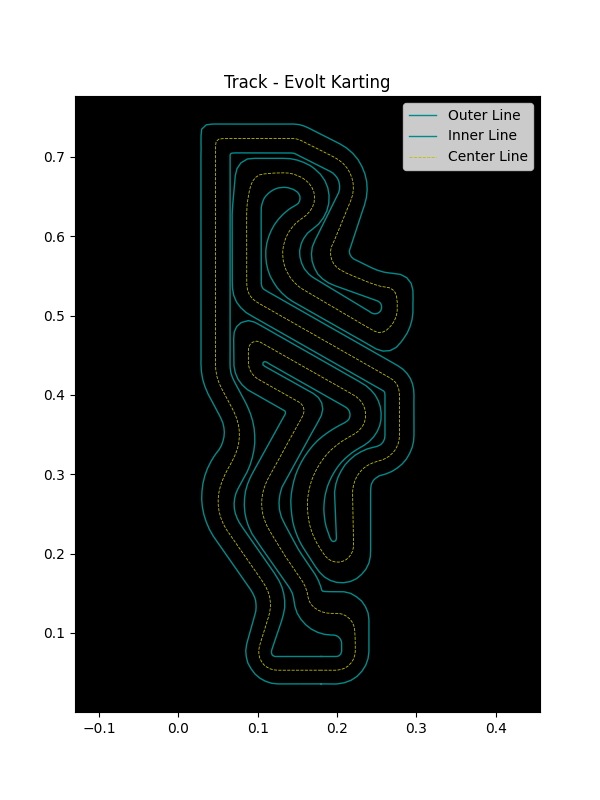

In [25]:
trackDrawer = trackDraw(plt, track_name)
trackDrawer.drawTrack2D(l_inner_line, l_outer_line)
trackDrawer.drawCenterLine(l_center_line)

trackDrawer.showPlot()

## Calculate the Racing Line

### Gradient Descent

#### Settings

In [38]:
N_ITERATIONS = 50
LEARNING_RATE = 0.001

In [39]:
if LEARNING_RATE <= 0 or LEARNING_RATE >= 1:
    raise Exception("Learning Rate should only be exclusive between (0,1)")

In [ ]:
# Racing Line Optimisation Algorithm - Implementation

### Post - Processing

In [ ]:
# Post-Processing Logics - Implementation

In [60]:
track_name = 'Track - Evolt Karting (Clockwise)'

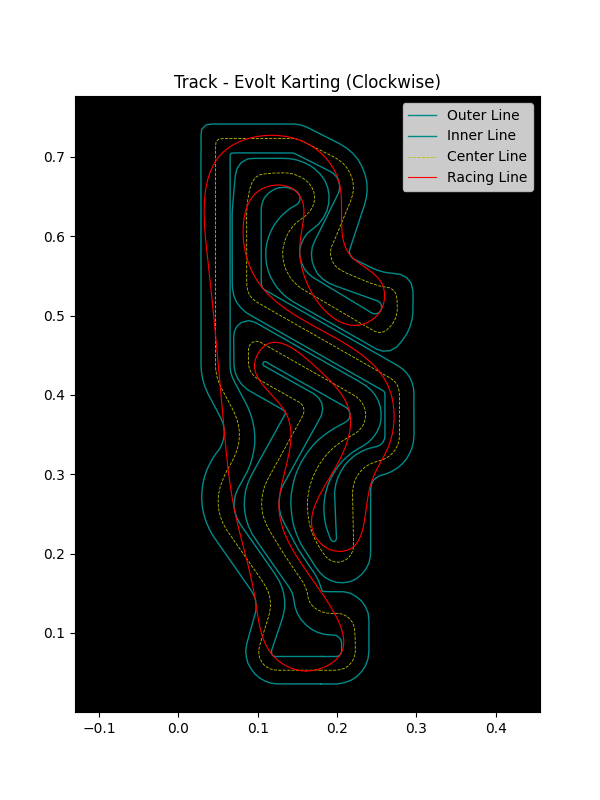

In [61]:
trackDrawer = trackDraw(plt, track_name)
trackDrawer.drawTrack2D(l_inner_line, l_outer_line)
trackDrawer.drawCenterLine(l_center_line)

trackDrawer.drawRacingLine(l_optimum_racing_line)

trackDrawer.showPlot()

### Animate the Racing Line

In [62]:
animationDrawer = trackDraw(plt, track_name)
animationDrawer.drawTrack2D(l_inner_line, l_outer_line)
animationDrawer.drawCenterLine(l_center_line)

animationDrawer.drawRacingLine(l_optimum_racing_line)

animationDrawer.showAnimatedRacingLine(optimum_racing_line)

## Conclusion

The Racing Line presented above was __theoretically calculated__ by using logics derived from :-
1) Informal documentation of K1999 Algorithm by Rémi Coulom, in his Thesis
1) "Programming Racing Lines" YouTube video by Javidx9 from OneLoneCoder

It is essential to note that the Racing Line is primarily valuable for achieving your fastest lap time during the __Qualifying__ phase.

During an __actual Race__, however, adhering strictly to the Racing Line might not guarantee a race victory, as racing often require racers to deviate from the line in order to overtake others.

> It's called a Motor Race. We went to Car Racing. - _Michael Masi, Abu Dhabi GP 2021_

As previously discussed in this notebook earlier, determining the optimal Racing Line is a complex task influenced by various interconnected factors, including:-
1) **Car Setup** - _Downforce, Brake Bias, etc_
1) **Tyres** - _Compound, Temperature, Degradation, etc_
1) **Racer Skills and Comfortability** - _Each racer would have different level of comfort with the car, traks, surrounding_
1) **Track Condition** - _Dry, Wet, Track Temperature, etc_
1) **Track Elevation Profile** - _Factor in elements such as bumps on straight lines, which affect the choice of Racing Line_
1) _Perhaps many more..._

Therefore, the presented Racing Line can be regarded as a theoretical concept.
It serves as a reference or starting point, offering a general idea of how to achieve speed on a given track.
However, it should be taken with a degree of flexibility, or I would say take it with a pinch of salt, will ya? 😄

With experience, racers often adjust their Racing Line to align with their unique racing styles and adapt to the ever-changing race scenarios.

## References

### Algorithms
1) The K1999 Path-Optimization Algorithm - https://www.remi-coulom.fr/Publications/Thesis.pdf (page 147)
1) deepracer-k1999-race-lines - https://github.com/cdthompson/deepracer-k1999-race-lines/tree/master
1) OneLoneCoder_RacingLines - https://github.com/OneLoneCoder/Javidx9/blob/master/ConsoleGameEngine/SmallerProjects/OneLoneCoder_RacingLines.cpp
1) Programming Racing Lines - https://youtu.be/FlieT66N9OM

### Maths
1) Introduction to Vectors and Their Operations - https://www.youtube.com/watch?v=KBSCMTYaH1s
1) The Vector Dot Product - https://www.youtube.com/watch?v=0iNrGpwZwog
1) Dot Product - https://www.mathsisfun.com/algebra/vectors-dot-product.html
1) Pythagoras' Theorem - https://www.mathsisfun.com/pythagoras.html